# Language Model Council Sample Notebook

The purpose of this notebook is to demonstrate some of the key functionalities of the lm-council library.

Please file a Github issue if you have questions or problems!

## Imports and setup

In [1]:
from lm_council.council import LanguageModelCouncil
from dotenv import load_dotenv


# Load OPENROUTER_API_KEY from .env file. 
# You will need to create a .env file with your API key if you haven't already.
load_dotenv()

True

You can test that the API key is loaded correctly by printing it out.

In [2]:
# import os
# print("OPENROUTER_API_KEY:", os.getenv("OPENROUTER_API_KEY"))

## Initialize the council

Model names can be found at https://openrouter.ai/models

Note that in order for the models to serve as judges, which all models are assigned as a judge by default, they must support structured outputs.

The list of models that support structured outputs can be found at https://openrouter.ai/models?fmt=cards&supported_parameters=response_format%2Cstructured_outputs

Unfortunately, structured outputs for Anthropic's models are not supported on OpenRouter.

In [3]:
lmc = LanguageModelCouncil(
    models=[
        "deepseek/deepseek-r1-0528",
        "google/gemini-2.5-flash-lite-preview-06-17",
        "x-ai/grok-3-mini",
        "meta-llama/llama-3.1-8b-instruct",
    ],
)

By default, all of the models on the council are designated to be judges. If only a subset of models should be judges, you'll need to specify this explicitly.

In [4]:
lmc = LanguageModelCouncil(
    models=[
        "deepseek/deepseek-r1-0528",
        "google/gemini-2.5-flash-lite-preview-06-17",
        "x-ai/grok-3-mini",
        "meta-llama/llama-3.1-8b-instruct",
        "anthropic/claude-3.5-haiku",
    ],
    judge_models=[
        "deepseek/deepseek-r1-0528",
        "google/gemini-2.5-flash-lite-preview-06-17",
    ],
)

By default, outputs are judged using a basic rubric looking at coherence and relevance on a 5 point scale, specified by an `EvaluationConfig`.

In [5]:
from lm_council.judging import PRESET_EVAL_CONFIGS
import yaml

print(yaml.dump(PRESET_EVAL_CONFIGS["default_rubric"]))

!!python/object:lm_council.judging.config.EvaluationConfig
__dict__:
  config: !!python/object:lm_council.judging.config.DirectAssessmentConfig
    __dict__:
      prebuilt_likert_scale: 5
      prompt_template: 'We would like to evaluate the quality of the response to a
        user prompt.


        ### USER PROMPT START ###

        {user_prompt}

        ### USER PROMPT END ###


        ### RESPONSE START ###

        {response}

        ### RESPONSE END ###


        Please evaluate the quality of the response based on the following criteria:


        {criteria_verbalized}


        Options:


        {likert_scale_verbalized}

        '
      rubric:
      - !!python/object:lm_council.judging.config.Criteria
        __dict__:
          name: Coherence
          statement: The response is coherent to the user prompt.
        __pydantic_extra__: null
        __pydantic_fields_set__: !!set
          name: null
          statement: null
        __pydantic_private__: null
      - !!

You can customize your evaluation config as you like.

There is also a default evaluation config for arena-style pairwise comparisons. Here's what that looks like.

In [6]:
print(yaml.dump(PRESET_EVAL_CONFIGS["default_pairwise"]))

!!python/object:lm_council.judging.config.EvaluationConfig
__dict__:
  config: !!python/object:lm_council.judging.config.PairwiseComparisonConfig
    __dict__:
      algorithm_config: !!python/object:lm_council.judging.config.PairwiseComparisonFixedReferencesConfig
        __dict__:
          reference_models:
          - google/gemini-2.5-flash-lite-preview-06-17
        __pydantic_extra__: null
        __pydantic_fields_set__: !!set
          reference_models: null
        __pydantic_private__: null
      algorithm_type: fixed_reference_models
      granularity: 4
      position_flipping: false
      prompt_template: 'Two models provided a response to a user prompt.


        ### USER PROMPT START ###

        {user_prompt}

        ### USER PROMPT END ###


        We want to decide which response is better. To assses quality, think about
        coherence and relevance.


        ### RESPONSE A START ###

        {response_1}

        ### RESPONSE A END ###


        ### RESPONSE B

For this demonstration, let's use the default pairwise evaluation configuration, with a subset of models as judges.

In [ ]:
lmc = LanguageModelCouncil(
    models=[
        "deepseek/deepseek-r1-0528",
        "google/gemini-2.5-flash-lite-preview-06-17",
        "x-ai/grok-3-mini",
        "meta-llama/llama-3.1-8b-instruct",
        "anthropic/claude-3.5-haiku",
    ],
    judge_models=[
        "deepseek/deepseek-r1-0528",
        "google/gemini-2.5-flash-lite-preview-06-17",
        "x-ai/grok-3-mini",
    ],
    eval_config=PRESET_EVAL_CONFIGS["default_pairwise"],
)

## Run the council

Run the council on a single prompt of your choosing.

`lmc.execute()` will send over the prompt to every model on the council and get their responses. After all of the responses are gathered, the prompt and response are sent to the judge models for judging.

In [8]:
# Run the council on any prompt of your choosing.
completion, judgment = await lmc.execute("Say hello.")

Generated 5 completion tasks.


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Generated 9 judging tasks.


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


In [9]:
completion

,user_prompt,model,completion_text,completion_tokens,prompt_tokens,total_tokens
0,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,Hello! How can I help you today?,9,3,12
1,Say hello.,anthropic/claude-3.5-haiku,Hello! How are you doing today?,11,10,21
2,Say hello.,meta-llama/llama-3.1-8b-instruct,Hello! How can I assist you today?,10,13,23
3,Say hello.,x-ai/grok-3-mini,Hello! How can I assist you today? 😊,337,9,346
4,Say hello.,deepseek/deepseek-r1-0528,Hello! 👋 How can I assist you today?,174,9,183


In [10]:
judgment

,user_prompt,judge_model,first_completion_by,second_completion_by,temperature,completion_tokens,prompt_tokens,total_tokens,pairwise_choice
0,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,google/gemini-2.5-flash-lite-preview-06-17,meta-llama/llama-3.1-8b-instruct,None,18,367,385,A>B
1,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,anthropic/claude-3.5-haiku,google/gemini-2.5-flash-lite-preview-06-17,None,17,366,383,A>B
2,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,deepseek/deepseek-r1-0528,google/gemini-2.5-flash-lite-preview-06-17,None,18,368,386,A>B
3,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,meta-llama/llama-3.1-8b-instruct,google/gemini-2.5-flash-lite-preview-06-17,None,18,367,385,A>B
4,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,x-ai/grok-3-mini,google/gemini-2.5-flash-lite-preview-06-17,None,13,368,381,A>B
5,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,google/gemini-2.5-flash-lite-preview-06-17,deepseek/deepseek-r1-0528,None,13,368,381,A>B
6,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,google/gemini-2.5-flash-lite-preview-06-17,x-ai/grok-3-mini,None,18,368,386,B>A
7,Say hello.,google/gemini-2.5-flash-lite-preview-06-17,google/gemini-2.5-flash-lite-preview-06-17,anthropic/claude-3.5-haiku,None,18,366,384,A>B
8,Say hello.,deepseek/deepseek-r1-0528,x-ai/grok-3-mini,google/gemini-2.5-flash-lite-preview-06-17,None,14,352,366,A>B
9,Say hello.,deepseek/deepseek-r1-0528,deepseek/deepseek-r1-0528,google/gemini-2.5-flash-lite-preview-06-17,None,16,351,367,A>>B


## Generate the leaderboard

Using reference LLM from config: google/gemini-2.5-flash-lite-preview-06-17


bootstrap: 100%|██████████| 10/10 [00:00<00:00, 575.21it/s]


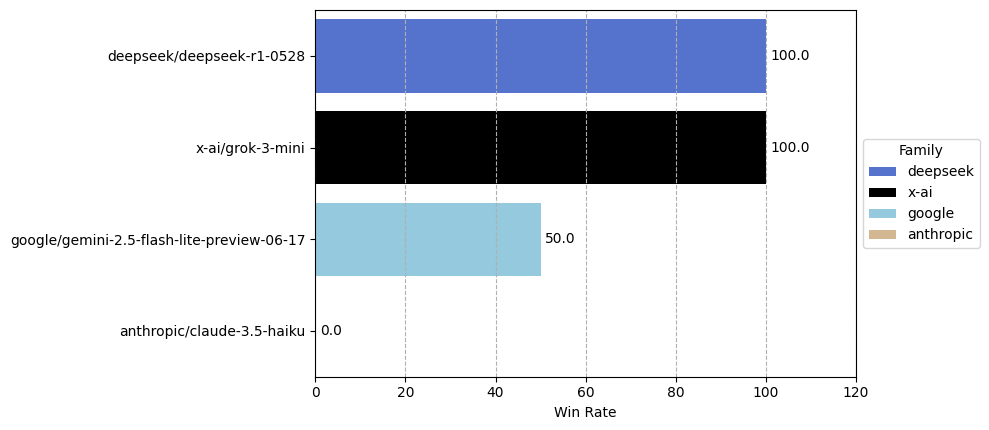

{'council/no-aggregation': {'elo_scores':                                              results  \
  1  [4375.842682019911, 4375.842682019911, 4375.84...   
  0  [4375.842682019911, 4375.842682019911, 4375.84...   
  2  [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
  3  [-2258.287169934272, -2258.287169934272, -2258...   
  
                                          model  score  lower  upper  lower_ci  \
  1                   deepseek/deepseek-r1-0528  100.0  100.0  100.0       0.0   
  0                            x-ai/grok-3-mini  100.0  100.0  100.0       0.0   
  2  google/gemini-2.5-flash-lite-preview-06-17   50.0   50.0   50.0       0.0   
  3                  anthropic/claude-3.5-haiku    0.0    0.0    0.0       0.0   
  
     upper_ci score_with_ci_str     family  lower_error  upper_error  
  1       0.0  100.0 (0.0, 0.0)   deepseek          0.0          0.0  
  0       0.0  100.0 (0.0, 0.0)       x-ai          0.0          0.0  
  2       0.0   50.0 (0.0, 0.0)     googl

In [10]:
lmc.leaderboard()

The leaderboard for pairwise evaluation configuration is based on estimated win rate (or ELO score) based on the Bradley-Terry algorithm.

## Get more data

Let's try a few additional prompts to make this more interesting.

In [16]:
completions, judgements = await lmc.execute(["Say goodbye.", "What is your name?", "What is 1 + 1?"])

Generated 15 completion tasks.


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Generated 30 judging tasks.


100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


## Regenerate the leaderboard

Using reference LLM from config: google/gemini-2.5-flash-lite-preview-06-17


bootstrap: 100%|██████████| 10/10 [00:00<00:00, 766.33it/s]


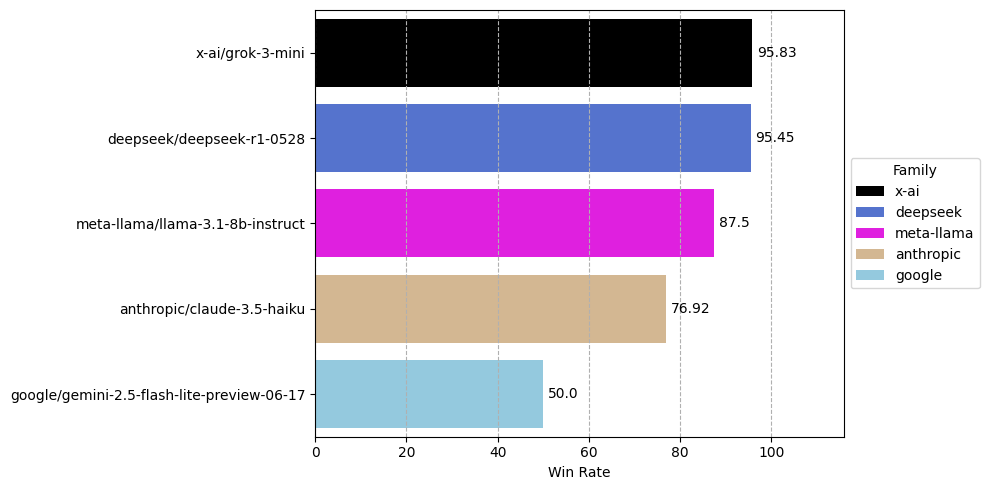

{'council/no-aggregation': {'elo_scores':                                              results  \
  0  [1544.6911108676213, 1544.6911108676213, 1544....   
  1  [1528.8877285751691, 1528.8877285751691, 1528....   
  2  [1338.0392131959165, 1338.0392131959165, 1338....   
  3  [1209.1515142240385, 1209.1515142240385, 1209....   
  4  [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
  
                                          model  score  lower  upper  lower_ci  \
  0                            x-ai/grok-3-mini  95.83  95.83  95.83       0.0   
  1                   deepseek/deepseek-r1-0528  95.45  95.45  95.45       0.0   
  2            meta-llama/llama-3.1-8b-instruct  87.50  87.50  87.50       0.0   
  3                  anthropic/claude-3.5-haiku  76.92  76.92  76.92       0.0   
  4  google/gemini-2.5-flash-lite-preview-06-17  50.00  50.00  50.00       0.0   
  
     upper_ci score_with_ci_str      family  lower_error  upper_error  
  0       0.0  95.83 (0.0, 0.0)        x-a

In [ ]:
lmc.leaderboard()

## Explicit win rate heatmap

See the explicit head-to-head win rates.

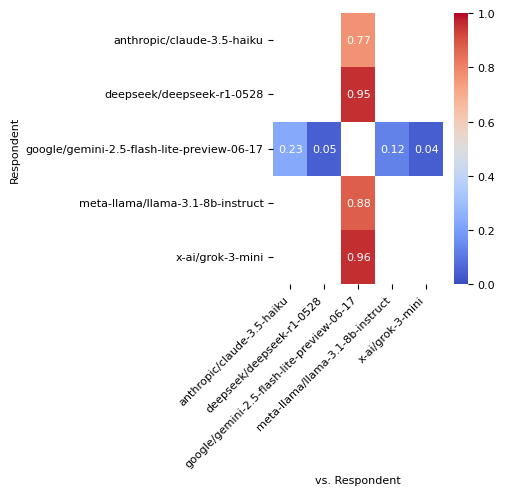

,anthropic/claude-3.5-haiku,deepseek/deepseek-r1-0528,google/gemini-2.5-flash-lite-preview-06-17,meta-llama/llama-3.1-8b-instruct,x-ai/grok-3-mini
anthropic/claude-3.5-haiku,NaN,NaN,0.769231,NaN,NaN
deepseek/deepseek-r1-0528,NaN,NaN,0.954545,NaN,NaN
google/gemini-2.5-flash-lite-preview-06-17,0.230769,0.045455,NaN,0.125,0.041667
meta-llama/llama-3.1-8b-instruct,NaN,NaN,0.875000,NaN,NaN
x-ai/grok-3-mini,NaN,NaN,0.958333,NaN,NaN


In [20]:
lmc.explicit_win_rate_heatmap()

## Affinity analysis

See single judge scores.

Using reference LLM from config: google/gemini-2.5-flash-lite-preview-06-17


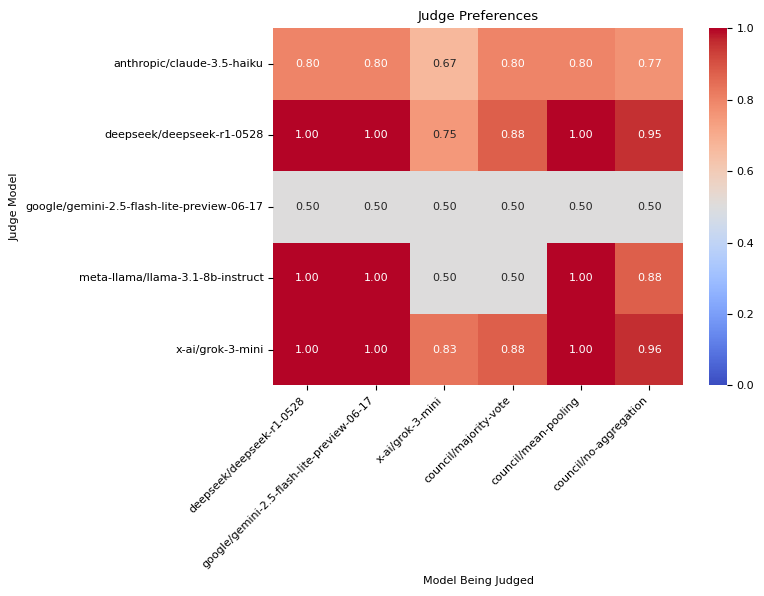

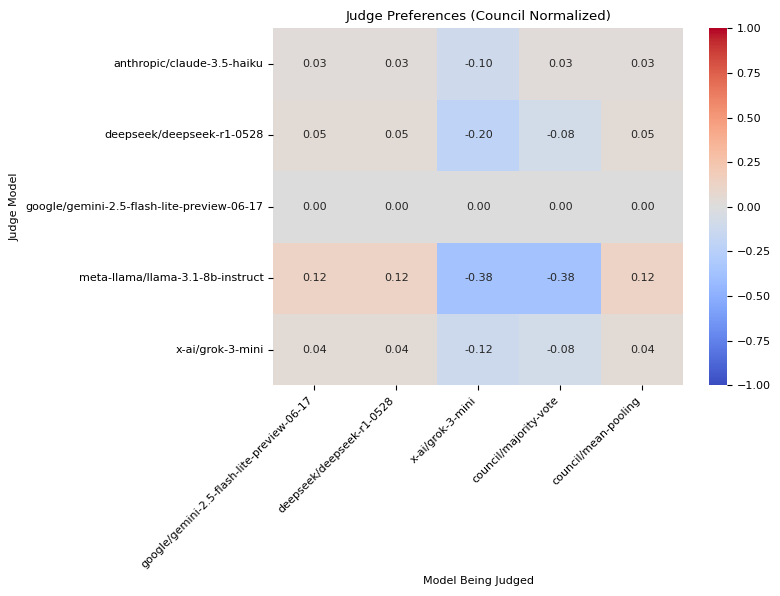

{'judge_preferences':                                             deepseek/deepseek-r1-0528  \
 anthropic/claude-3.5-haiku                                        0.8   
 deepseek/deepseek-r1-0528                                         1.0   
 google/gemini-2.5-flash-lite-preview-06-17                        0.5   
 meta-llama/llama-3.1-8b-instruct                                  1.0   
 x-ai/grok-3-mini                                                  1.0   
 
                                             google/gemini-2.5-flash-lite-preview-06-17  \
 anthropic/claude-3.5-haiku                                                         0.8   
 deepseek/deepseek-r1-0528                                                          1.0   
 google/gemini-2.5-flash-lite-preview-06-17                                         0.5   
 meta-llama/llama-3.1-8b-instruct                                                   1.0   
 x-ai/grok-3-mini                                                             

In [ ]:
lmc.affinity(show_plots=True)

## Agreement

Find the agreement between judges.

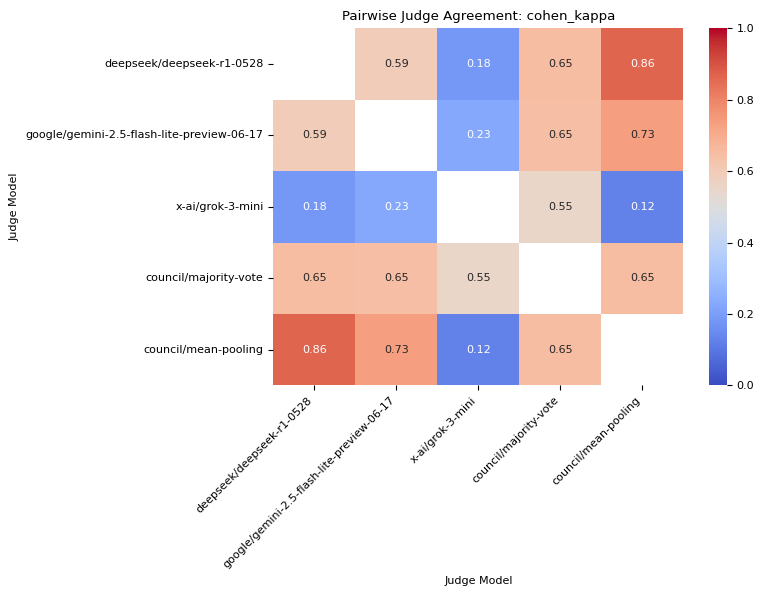

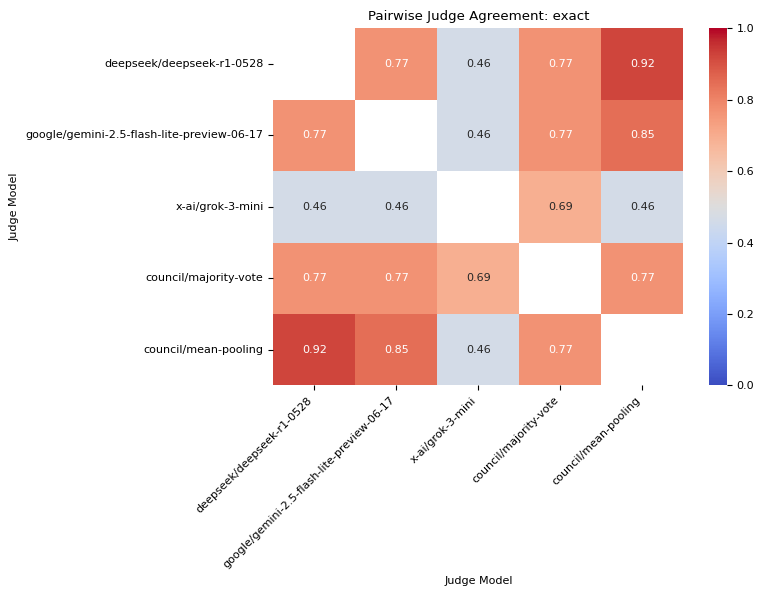

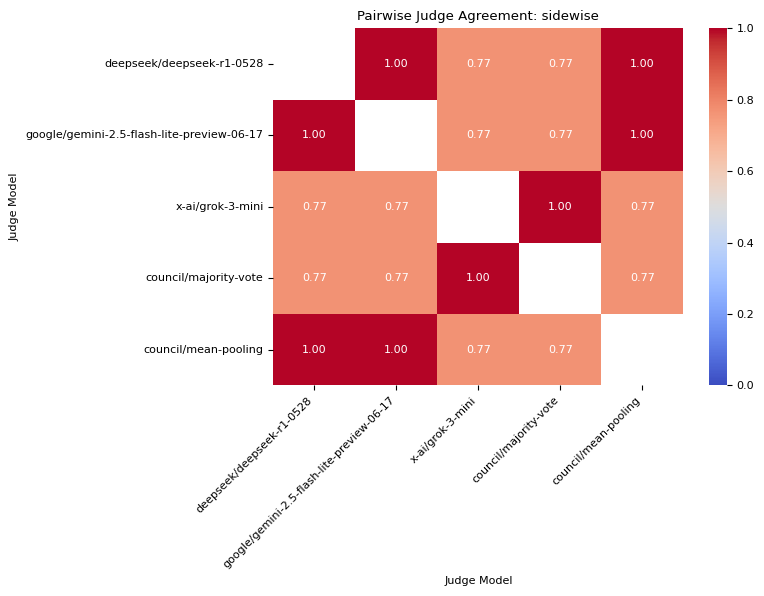

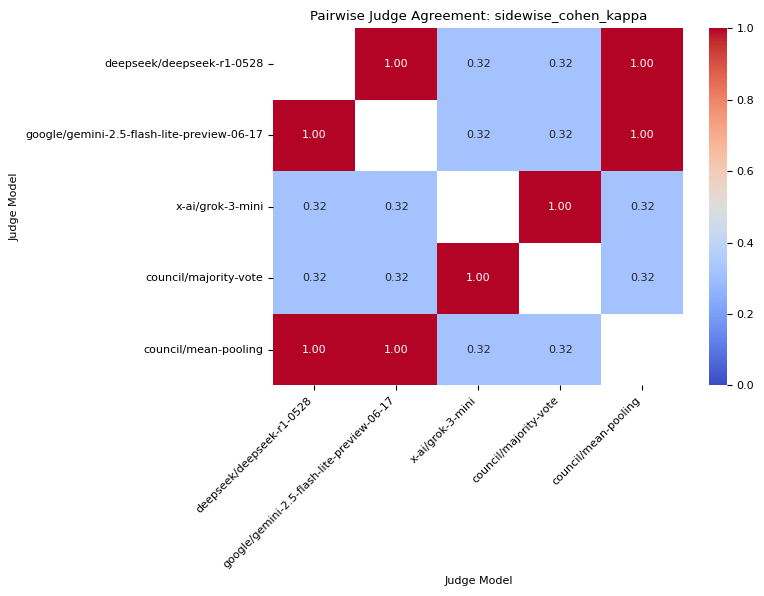

({'cohen_kappa':                                             deepseek/deepseek-r1-0528  \
  deepseek/deepseek-r1-0528                                         NaN   
  google/gemini-2.5-flash-lite-preview-06-17                   0.593750   
  x-ai/grok-3-mini                                             0.180180   
  council/majority-vote                                        0.648649   
  council/mean-pooling                                         0.864583   
  
                                              google/gemini-2.5-flash-lite-preview-06-17  \
  deepseek/deepseek-r1-0528                                                     0.593750   
  google/gemini-2.5-flash-lite-preview-06-17                                         NaN   
  x-ai/grok-3-mini                                                              0.228814   
  council/majority-vote                                                         0.645455   
  council/mean-pooling                                                  

In [21]:
lmc.judge_agreement(show_plots=True)

## Save to and load from disk

In [22]:
lmc.save("run_0")
lmc.load("run_0")

## Upload to HF datasets

In [ ]:
lmc.upload_to_hf("<username>/<dataset_name_of_your_choice>")